In [1]:
# imports
import os
import re
import torch
from IPython.display import display
from diffusers import StableDiffusionPipeline
from diffusers import DPMSolverMultistepScheduler
from diffusers import AutoencoderKL


In [2]:
# Directory containing the prompt files
prompt_dir = "./prompts/"  

# Load all .txt files
p = []
for filename in os.listdir(prompt_dir):
    if filename.endswith(".txt"):
        with open(os.path.join(prompt_dir, filename), "r") as file:
            p.append(file.read())

prompts = {}
# Loop through prompts and extract album name and other details
for i, prompt in enumerate(p, 1):
    # Use regex to extract album name
    album_name_match = re.search(r"Album name\s*:\s*(.+)", prompt)
    if album_name_match:
        album_name = album_name_match.group(1).strip()  # Extract and clean the album name
        
        # Extract additional details using regex
        artist = re.search(r"Artist\s*:\s*(.+)", prompt).group(1).strip() if re.search(r"Artist\s*:\s*(.+)", prompt) else "Unknown Artist"
        release_date = re.search(r"Release Date\s*:\s*(.+)", prompt).group(1).strip() if re.search(r"Release Date\s*:\s*(.+)", prompt) else "Unknown Date"
        label = re.search(r"Label\s*:\s*(.+)", prompt).group(1).strip() if re.search(r"Label\s*:\s*(.+)", prompt) else "Unknown Label"
        
        # Extract tracks separately
        tracks = re.findall(r"\d+\.\s*([^by]+) by.*", prompt)
        
        # Add all extracted details to the prompts dictionary
        prompts[album_name] = {
            "artist": artist,
            "release_date": release_date,
            "label": label,
            "tracks": tracks,
            "prompt": prompt
        }

# # Print the dictionary with structured information
# for album_name, details in prompts.items():
#     print(f"Album Name: {album_name}")
#     print(f"Artist: {details['artist']}")
#     print(f"Release Date: {details['release_date']}")
#     print(f"Label: {details['label']}")
#     print(f"Tracks: {', '.join(details['tracks'])}")
#     print(f"Prompt: {details['prompt']}\n{'-' * 50}")

In [ ]:
# Stable Diffusion model: https://huggingface.co/stabilityai/stable-diffusion-2
# Load the model
pipe = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2", torch_dtype=torch.float32) 
pipe = pipe.to("cuda")  # Use "cpu" if CUDA is not available
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config) 

#to improve quality 
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse", torch_dtype=torch.float32).to("cuda")
pipe.vae = vae   

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/home/mow/miniconda3/envs/msgai/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### Generation album cover without text allowed (test)

*NOTE*: I'll have to tweak the code to make it possible to select manually which prompt I want in my prompts dic and not just the first one OR to generate art for all?

ALSO gonna have to work on the no-text part because it still adds text ! But idea is to get an image without text and adding it later?

In [4]:
# Define a more concise prompt to get as many information as possible despite tokens limit WITHOUT TEXT
album_name = (list(prompts.keys()))
concise_prompt = f"Create an image that represents the album {album_name[0]} which contains the tracks {prompts.get(album_name[0],{}).get('tracks', 'tracks not found')} released in {prompts.get(album_name[0],{}).get('release_date', 'release date not found')}."

  0%|          | 0/50 [00:00<?, ?it/s]

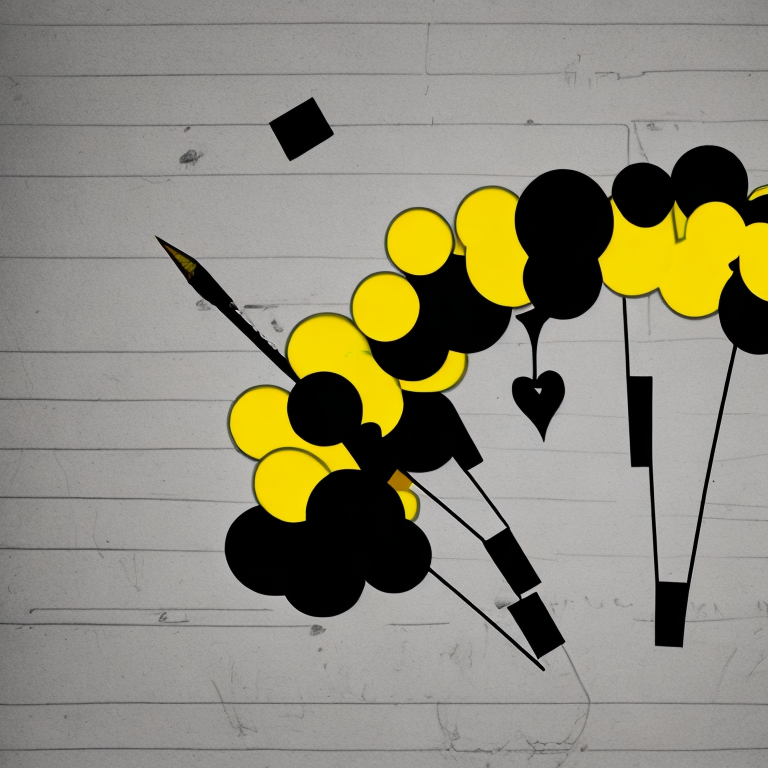

In [ ]:
# Generate the album cover
image = pipe(concise_prompt).images[0]

file_directory = "./art_cover/"

# Create the directory if it doesn't exist
os.makedirs(file_directory, exist_ok=True)
# Save and display the generated image
image.save(f"{file_directory}/{album_name[0]}_cover.png") # change this to get good file 
image.show()  # Opens the image here


### Generation album cover with text allowed

And this one not always put some labels on so gotta see what we can do

In [8]:
# Define a more concise prompt to get as many information as possible despite tokens limit TEXT ALLOWED
album_name = (list(prompts.keys()))
concise_prompt_text = f"Create an album cover with the title {album_name[0]} and artist {prompts.get(album_name[0],{}).get('artist', 'artist not found')} bases on the tracks {prompts.get(album_name[0],{}).get('tracks', 'tracks not found')} released in {prompts.get(album_name[0],{}).get('release_date', 'release date not found')}."
print(concise_prompt)

Create an album cover art without text for the album Bruise which contains the tracks ['Addict', 'Gas Lighting', 'Yellow Paint', 'Love No More', 'Games', 'Knocked for Six', 'Machines', 'Balloon'] released in 2020-03-27.


  0%|          | 0/50 [00:00<?, ?it/s]

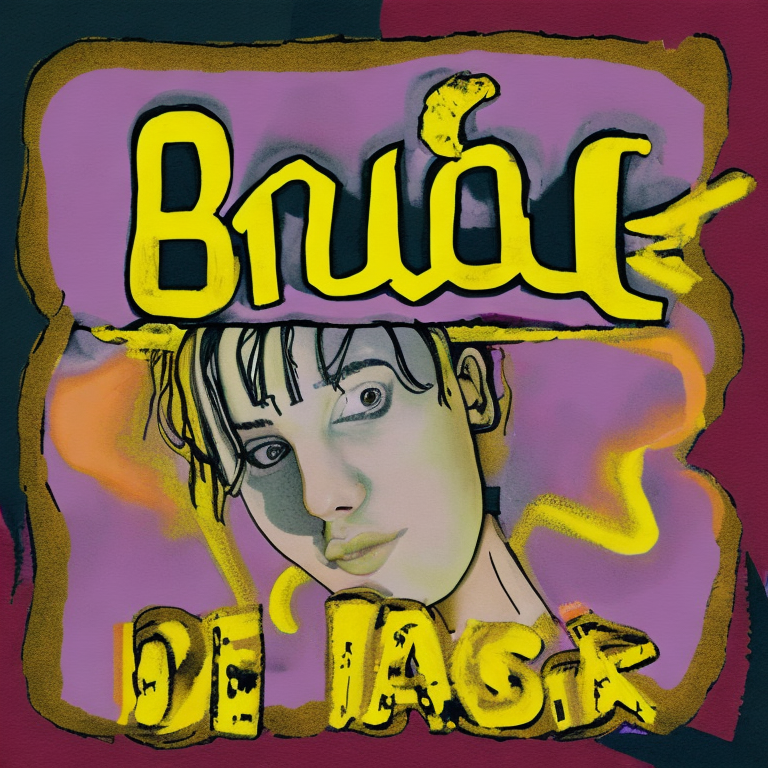

In [7]:
# Generate the album cover
image = pipe(concise_prompt_text).images[0]

file_directory = "./art_cover/"

# Create the directory if it doesn't exist
os.makedirs(file_directory, exist_ok=True)
# Save and display the generated image
image.save(f"{file_directory}/{album_name[0]}_cover_text.png") # change this to get good file 
image.show()  # Opens the image here


## Parametrization

In [26]:
import torch
torch.cuda.empty_cache()

In [23]:
generator = torch.Generator("cuda").manual_seed(0)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [24]:
# Define a more concise prompt to get as many information as possible despite tokens limit WITHOUT TEXT
album_name = (list(prompts.keys()))
concise_prompt = f"Create an album cover art for the album {album_name[0]} which contains the tracks {prompts.get(album_name[0],{}).get('tracks', 'tracks not found')} released in {prompts.get(album_name[0],{}).get('release_date', 'release date not found')}."
negative_prompt = "text"

  0%|          | 0/20 [00:00<?, ?it/s]

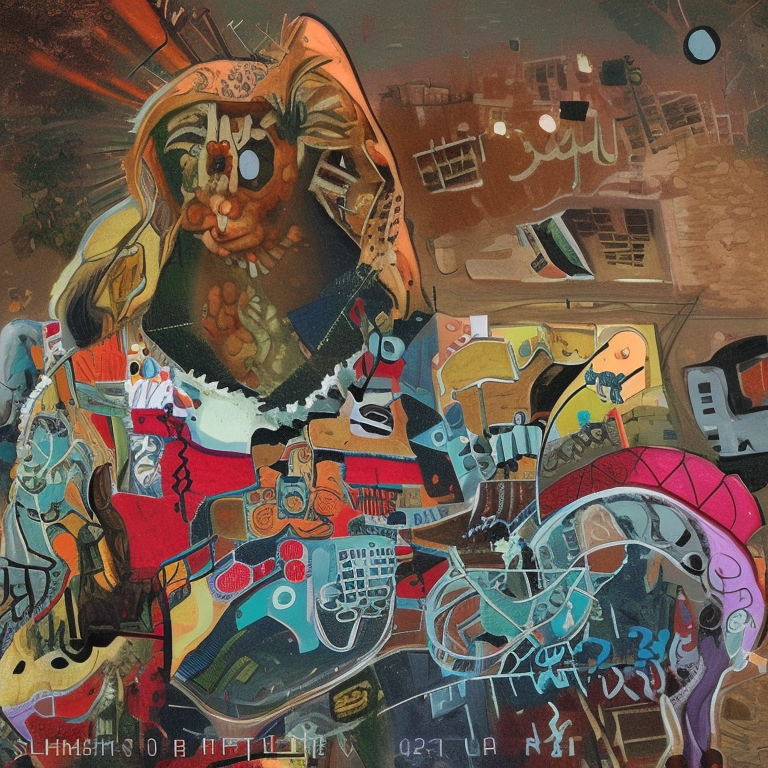

In [25]:
image = pipe(
    prompt= concise_prompt,
    generator=generator,
    negative_prompt= negative_prompt,
    guidance_scale= 1-5, #the higher the more it follows the prompt BUT lose in creativity
    num_inference_steps= 20, #the lower the faster but lose in quality 
    batch_size= 2,    
).images[0]

file_directory = "./art_cover/"

# Create the directory if it doesn't exist
os.makedirs(file_directory, exist_ok=True)
# Save and display the generated image
image.save(f"{file_directory}/{album_name[0]}_cover_parameters.png") # change this to get good file 
image.show()  # Opens the image here


### To generate several images at the same time (in a grid)

In [27]:
import torch
torch.cuda.empty_cache()

In [4]:
album_name = (list(prompts.keys()))
concise_prompts = [f"Album cover for {album_name[0]} with {prompts.get(album_name[0],{}).get('tracks', 'tracks not found')}", 
                   f"Album cover for {album_name[0]}",
                   f"Create an album cover art for the album {album_name[0]} which contains the tracks {prompts.get(album_name[0],{}).get('tracks', 'tracks not found')} released in {prompts.get(album_name[0],{}).get('release_date', 'release date not found')}",
                   f"Album cover for these tracks {prompts.get(album_name[0],{}).get('tracks', 'tracks not found')}"]
negative_prompt = "text"

In [5]:
def get_inputs(batch_size=1):                                                                                                                                                                                                                 
  generator = [torch.Generator("cuda").manual_seed(i) for i in range(batch_size)]                                                                                                                                                             
  prompts = concise_prompts                                                                                                                                                                                                             
  num_inference_steps = 20
  negative_prompts = batch_size*[negative_prompt]                                                                                                                                                                                                                   

  return {"prompt": prompts, "generator": generator, "num_inference_steps": num_inference_steps, "negative_prompt":negative_prompts}                                                                                                                                              

In [6]:
from PIL import Image                                                                                                                                                                                                                         

def save_and_display_images(imgs, output_dir="./art_cover"):
    os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist
    for idx, img in enumerate(imgs):
        img_path = os.path.join(output_dir, f"image_{idx + 1}.png")
        img.save(img_path)
        print(f"Saved: {img_path}")
        
        # Display the image in the notebook
        display(img)                                                                                                                                                                                                                      

In [7]:
pipe.enable_attention_slicing()     
images = pipe(**get_inputs(batch_size=4)).images                                                                                                                                                                                              
save_and_display_images(images) 

  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Essais avec un autre model

In [11]:
model_id = "sd-legacy/stable-diffusion-v1-5"
pipe_small = StableDiffusionPipeline.from_pretrained(model_id) #could also add a torch.float something is needed
pipe_small = pipe_small.to("cuda")

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/home/mow/miniconda3/envs/msgai/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

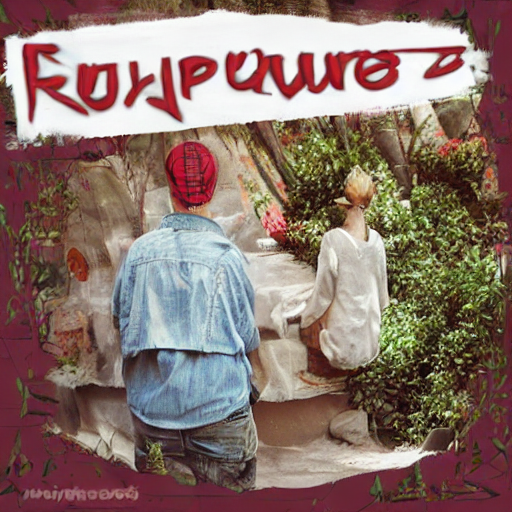

In [ ]:
image = pipe_small(
    prompt= concise_prompt,
    negative_prompt= negative_prompt,
    guidance_scale= 1-5, #the higher the more it follows the prompt BUT lose in creativity
    num_inference_steps= 100, #the lower the faster but lose in quality 
    batch_size= 2,
).images[0]

file_directory = "./art_cover/"

# Create the directory if it doesn't exist
os.makedirs(file_directory, exist_ok=True)
# Save and display the generated image
image.save(f"{file_directory}/{album_name[0]}_cover_parameters_small.png") # change this to get good file 
image.show()  # Opens the image here

(1) identifier les critères qui influence la qualité et la latency

(2) regarder s'il y a une manière simple de switcher entre le version avec et sans texte

(3) Noter les paramètres nécessaires pour chaque service request

(4) try different prompts

- https://huggingface.co/docs/diffusers/v0.14.0/en/stable_diffusion
- https://huggingface.co/blog/stable_diffusion
- https://huggingface.co/docs/diffusers/using-diffusers/loading
- https://huggingface.co/docs/diffusers/v0.9.0/en/training/text2image
- https://huggingface.co/docs/diffusers/main/en/using-diffusers/write_own_pipeline